In [1]:
import random
import numpy as np
import torch

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [2]:
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.ipython_useSVG = True
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.addBondIndices = False
IPythonConsole.molSize = (200, 200)

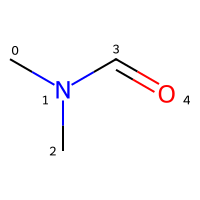

In [3]:
# N,N-dimethylformamide (DMF)
dmf_smiles = "CN(C)C=O"
mol = MolFromSmiles(dmf_smiles)

mol

In [4]:
#Atom Featues

ATOM_FEATURES = {
    'atom_type' : [1, 6, 7, 8, 9],  # elements: H, C, N, O, F
    'degree' : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 'misc'],
    'formal_charge' : [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 'misc'],
    'hybridization' : [
        'SP', 'SP2', 'SP3', 'SP3D', 'SP3D2', 'misc'
        ],
}

In [5]:
def get_atom_fv(atom):
    atom_fv = [
        ATOM_FEATURES['atom_type'].index(atom.GetAtomicNum()),
        ATOM_FEATURES['degree'].index(atom.GetTotalDegree()),
        ATOM_FEATURES['formal_charge'].index(atom.GetFormalCharge()),
        ATOM_FEATURES['hybridization'].index(str(atom.GetHybridization())),
    ]
    
    return atom_fv


In [6]:
atom_fvs = [get_atom_fv(atom) for atom in mol.GetAtoms()]
atom_fvs

[[1, 4, 5, 2], [2, 3, 5, 1], [1, 4, 5, 2], [1, 3, 5, 1], [3, 1, 5, 1]]

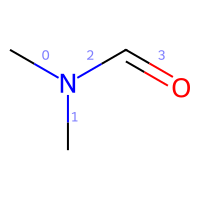

In [7]:
IPythonConsole.drawOptions.addAtomIndices = False  
IPythonConsole.drawOptions.addBondIndices = True 
mol

In [8]:
BOND_FEATURES = {
    'bond_type' : [
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
        'misc'
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ], 
    'conjugated': [False, True],
}

In [9]:
def get_bond_fv(bond):
    bond_fv = [
        BOND_FEATURES['bond_type'].index(str(bond.GetBondType())),
        BOND_FEATURES['stereo'].index(str(bond.GetStereo())),
        BOND_FEATURES['conjugated'].index(bond.GetIsConjugated()),
    ]
    return bond_fv

In [10]:
bond_fvs = [get_bond_fv(bond) for bond in mol.GetBonds()]
bond_fvs

[[0, 0, 0], [0, 0, 0], [0, 0, 1], [1, 0, 1]]

In [11]:
edge_index0, edge_index1 = [], []

for bond in mol.GetBonds():
    i, j = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()

    edge_index0 += [i, j]
    edge_index1 += [j, i]

edge_index = [edge_index0, edge_index1]
edge_index

[[0, 1, 1, 2, 1, 3, 3, 4], [1, 0, 2, 1, 3, 1, 4, 3]]

In [12]:
import torch
from torch_geometric.data import Data

x = torch.tensor(atom_fvs, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
edge_attr = torch.tensor(bond_fvs, dtype=torch.float)

y = torch.tensor([0.944], dtype=torch.float) # Density of DMF in g/cm3

dmf_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
dmf_data

Data(x=[5, 4], edge_index=[2, 8], edge_attr=[4, 3], y=[1])

In [13]:
import torch
import torch.nn.functional as F
from torch.nn import GRU
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch_geometric.loader import DataLoader
from torch_geometric.nn import NNConv, MLP, global_add_pool
from ogb.graphproppred.mol_encoder import AtomEncoder, BondEncoder

c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\outdated\__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [17]:
class MPNN(pl.LightningModule):
    def __init__(self, hidden_dim, out_dim, train_data, valid_data, test_data, std, batch_size=32, lr=1e-3):
        super().__init__()
        self.std = std
        self.train_data = train_data
        self.valid_data = valid_data
        self.test_data = test_data
        self.batch_size = batch_size
        self.lr = lr

        self.atom_emb = AtomEncoder(emb_dim=hidden_dim)
        self.bond_emb = BondEncoder(emb_dim=hidden_dim)

        nn = MLP([hidden_dim, hidden_dim * 2, hidden_dim * hidden_dim],)
        self.conv = NNConv(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            nn=nn,
            aggr='mean'
        )
        self.gru = GRU(hidden_dim, hidden_dim)

        self.mlp = MLP([hidden_dim, int(hidden_dim/2), out_dim])

    def forward(self, data, mode = 'train'):

        x = self.atom_emb(data.x)
        h = x.unsqueeze(0)
        edge_attr = self.bond_emb(data.edge_attr)

        #passing messages within 3 distance
        for i in range(3):
            m = F.relu(self.conv(x, data.edge_index, edge_attr))
            x, h = self.gru(m.unsqueeze(0), h)
            x = x.squeeze(0)

        x = global_add_pool(x, data.batch)
        x = self.mlp(x)

        return x.view(-1)


    def training_step(self, batch, batch_idx):
        # Here we define the train loop.
        out = self.forward(batch, mode="train")
        loss = F.mse_loss(out, batch.y)
        self.log("Train loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        # Define validation step. At the end of every epoch, this will be executed
        out = self.forward(batch, mode="valid")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("Valid MSE", loss)
        
    def test_step(self, batch, batch_idx):
        # What to do in test
        out = self.forward(batch, mode="test")
        loss = F.mse_loss(out * self.std, batch.y * self.std)  # report MSE
        self.log("Test MSE", loss)

    def configure_optimizers(self):
        # Here we configure the optimization algorithm.
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.lr
        )
        return optimizer
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)
    
    def val_dataloader(self):
        return DataLoader(self.valid_data, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, shuffle=False)

In [23]:
from tqdm import tqdm
import pandas as pd
import torch
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
)
from ogb.utils import smiles2graph


class ESOLGraphData(InMemoryDataset):
    # ESOL dataset download link
    raw_url = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'

    def __init__(self, root, transform=None):
        super().__init__(root, transform)
        self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)

    @property
    def raw_file_names(self):
        return ['delaney-processed.csv']

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        print('Downloading ESOL dataset...')
        file_path = download_url(self.raw_url, self.raw_dir)

    def process(self):
        # load raw data from a csv file
        df = pd.read_csv(self.raw_paths[0])
        smiles = df['smiles'].values.tolist()
        target = df['measured log solubility in mols per litre'].values.tolist()

        # Convert SMILES into graph data
        print('Converting SMILES strings into graphs...')
        data_list = []
        for i, smi in enumerate(tqdm(smiles)):

            # get graph data from SMILES
            graph = smiles2graph(smi)

            # convert to tensor and pyg data
            x = torch.tensor(graph['node_feat'], dtype=torch.long)
            edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)
            edge_attr = torch.tensor(graph['edge_feat'], dtype=torch.long)
            y = torch.tensor([target[i]], dtype=torch.float)
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
            data_list.append(data)

        # save data
        torch.save(self.collate(data_list), self.processed_paths[0])

In [24]:
from typing import Optional, Tuple
import numpy as np
from torch_geometric.data.dataset import Dataset


class RandomSplitter(object):
    """Class for doing random data splits."""

    def split(
            self,
            dataset: Dataset,
            frac_train: float = 0.7,
            frac_valid: float = 0.1,
            frac_test: float = 0.2,
            seed: Optional[int] = None,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:  # A tuple of train indices, valid indices, and test indices. Each indices is a numpy array.
      
        np.testing.assert_almost_equal(frac_train + frac_valid + frac_test, 1.0)
        if seed is not None:
            np.random.seed(seed)

        num_datapoints = len(dataset)
        train_cutoff = int(frac_train * num_datapoints)
        valid_cutoff = int((frac_train + frac_valid) * num_datapoints)
        shuffled = np.random.permutation(range(num_datapoints))
        
        return (
            shuffled[:train_cutoff],
            shuffled[train_cutoff:valid_cutoff],
            shuffled[valid_cutoff:],
        )

In [25]:
dataset = ESOLGraphData('./esol_pyg').shuffle()

# Normalize target to mean = 0 and std = 1.
mean = dataset.data.y.mean()
std = dataset.data.y.std()
dataset.data.y = (dataset.data.y - mean) / std
mean, std = mean.item(), std.item()

# split data
splitter = RandomSplitter()
train_idx, valid_idx, test_idx = splitter.split(dataset, frac_train=0.7, frac_valid=0.1, frac_test=0.2)
train_dataset = dataset[train_idx]
valid_dataset = dataset[valid_idx]
test_dataset = dataset[test_idx]

C:\Users\aryan\AppData\Local\Temp\ipykernel_39596\1988486312.py:4: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  mean = dataset.data.y.mean()
C:\Users\aryan\AppData\Local\Temp\ipykernel_39596\1988486312.py:5: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The given 'InMemoryDataset' only references a subset of examples of the full dataset, but 'data' will contain information of the full dataset. If you are absolutely certain what you are doing, access the internal storage v

In [26]:
import wandb

wandb.init(project = "gnn-solubility",
           config = {
                "batch_size": 32,
               "learning_rate": 0.001,
               "hidden_size": 64,
               "max_epochs": 60
           })

wandb: Currently logged in as: accayo (accayo-iit-bombay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [ ]:
gnn_model = MPNN(
    hidden_dim=wandb.config["hidden_size"],
    out_dim=1,
    std=std,
    train_data=train_dataset,
    valid_data=valid_dataset,
    test_data=test_dataset,
    lr=wandb.config["learning_rate"],
    batch_size=wandb.config["batch_size"]
)

wandb_logger = WandbLogger()
trainer = pl.Trainer(
    max_epochs = wandb.config["max_epochs"],
    logger = wandb_logger
)

trainer.fit(
    model=gnn_model,
)

results = trainer.test(ckpt_path="best")
wandb.finish()

test_mse = results[0]["Test MSE"]
test_rmse = test_mse ** 0.5
print(f"\nMPNN model performance: RMSE on test set = {test_rmse:.4f}.\n")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\loggers\wandb.py:400: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name     | Type        | Params | Mode  | FLOPs
---------------------------------------------------------
0 | atom_emb | AtomEncoder | 11.1 K | train | 0    
1 | bond_emb | BondEncoder | 832    | train | 0    
2 | conv     | NNConv      | 541 K  | train | 0    
3 | gru      | GRU         | 25.0 K | train | 0    
4 | mlp      | MLP         | 2.2 K  | train | 0    
-----------------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 424. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 412. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\conn

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 462. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 230. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.
Restoring states from the checkpoint path at .\lightning_logs\6tulmvrj\checkpoints\epoch=59-step=1500.ckpt
Loaded model weights from the checkpoint at .\lightning_logs\6tulmvrj\checkpoints\epoch=59-step=1500.ckpt
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:434: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 360. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 365. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 405. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\aryan\AppData\Local\Programs\Python\Python313\Lib\site-packages\pytorch_lightning\utilities\data.py:79: Trying to infer the `batch_size` from an 

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test MSE            0.4682095944881439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Test MSE,▁
Train loss,▄▃▄█▇▃▁▂▅▁▁▄▂▂▂▁▂▅▄▂▁▂▂▂▃▁▁▂▂▂
Valid MSE,█▆▇▄▃▃▃▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▆▆▆▆▆▆▇▇▇▇▇████
Test MSE,0.46821
Train loss,0.07434
Valid MSE,0.64257
epoch,60
trainer/global_step,1500



MPNN model performance: RMSE on test set = 0.6843.

